## Transformer le fichier .xls en .csv

In [1]:
# ignore warnings
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

population = pd.read_excel('./raw/INSEE_population_2014.xls')

dict_columns = {'P14_POP0002' : '0 - 2',
                'P14_POP0305' : '3 - 5',
                'P14_POP0610' : '6 -10',
                'P14_POP1117' : '11 - 17',
                'P14_POP1824' : '18 - 24',
                'P14_POP2539' : '25 - 39',
                'P14_POP4054' : '40 - 54',
                'P14_POP5564' : '55 - 64',
                'P14_POP6579' : '65 - 79',
                'P14_POP80P'  : ' 80 + '}

population.rename(columns = dict_columns, inplace = True)

#### On formate les données en entier puisque ce sont des quantités de personnes

In [2]:
population = population.round().astype('int')

#### On sauvegarde le traitement en .csv

In [3]:
population.to_csv('population.csv', index = False)

# Feature selection
La sélection de variables basée sur des tests de dépendance.

#### Test de dépendance avec Chi-2
Avec choix des meilleurs k valeurs

In [15]:
from sklearn.feature_selection import SelectKBest, chi2

# X = Features, y = Target
X = population.iloc[:,1:10]
y = population.iloc[:,0]

selector = SelectKBest(chi2, k=1)
selector.fit(X, y)

X.columns[selector.get_support()]

Index(['25 - 39'], dtype='object')

#### Test de dépendance avec ANOVA
Avec choix des meilleures k valeurs

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

# X = Features, y = Target
X = population.iloc[:,4:10]
y = population.iloc[:,0]

selector = SelectKBest(f_classif, k=1)
selector.fit(X, y)

X.columns[selector.get_support()]

Index(['25 - 39'], dtype='object')

ANOVA rend compte de la dépendance avec les enfants et de la tranche d'âge suceptible d'avoir des enfants.

#### Test de dépendance avec Corrélation de Pearson

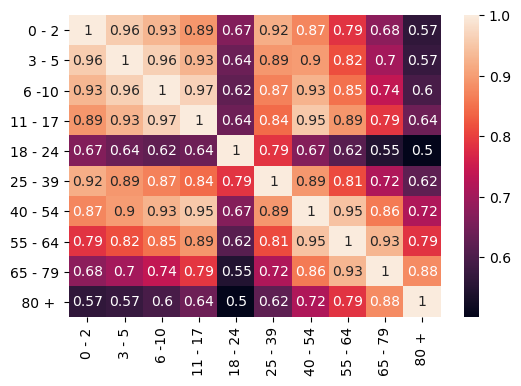

In [6]:
plt.figure(dpi=100)
sns.heatmap(population.corr(), annot = True);

#### Conclusion
Pour prédire la variable y (quantité d'enfants de 0-2 ans ), on utilisera la variable X des '25-39' ans

## Preprocessing : Normalisation ( 0 encodage à faire )
#### On utilise une classe transformer du module preprocessing robuste aux valeurs aberrantes. Utilisation de la métrique boxplot

Les données sont normalisées entre - 1 et 1 sauf les outliers.

In [7]:
from sklearn.preprocessing import RobustScaler

dataset = np.array(population)

# standardization : mean = 0, std = 1
scaler_array = RobustScaler().fit_transform(dataset)

print(pd.DataFrame(scaler_array[:,0:7]).head(3))

          0         1         2         3         4         5         6
0  0.046875 -0.166667  0.054545  0.121795 -0.051613 -0.075802  0.056150
1 -0.187500 -0.287879 -0.336364 -0.301282 -0.232258 -0.230321 -0.328877
2  0.765625  0.530303  0.454545  0.243590  1.458065  0.626822  0.280749


## Machine learning 
##### **Développer un modèle mathématique à partir de données experimentales**

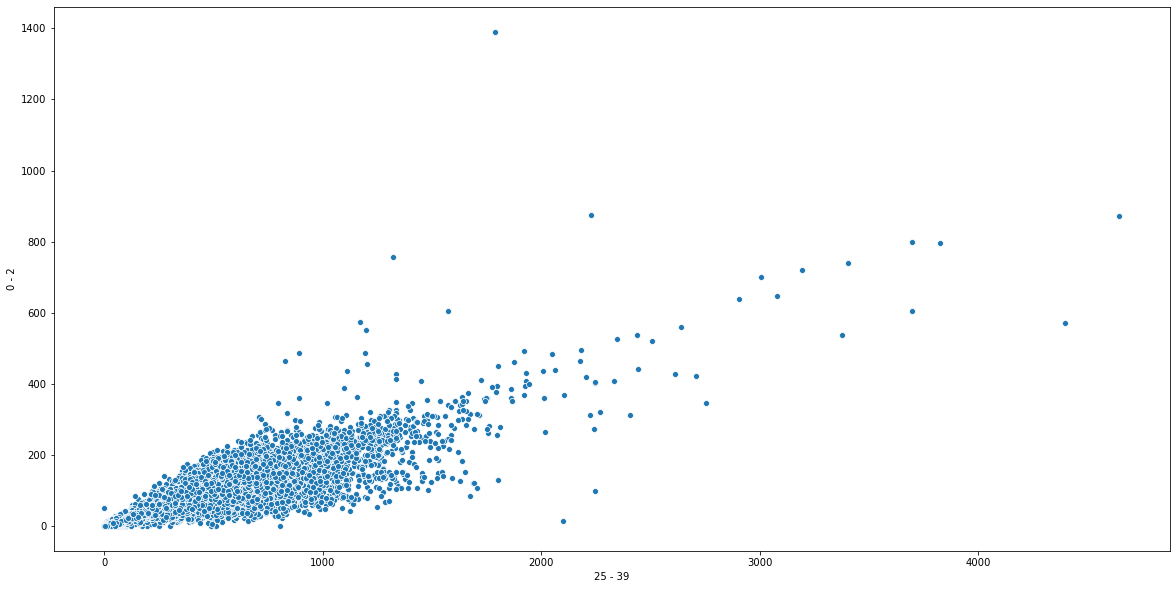

In [8]:
plt.figure(figsize = (20,10))
sns.scatterplot(x = '25 - 39', y = '0 - 2', data = population);

## Sélectionner le modèle mathématique , Entrainer, Evaluer et Prédire

## Train et Test : passé et futur

Train score :  0.84
Test  score :  0.86


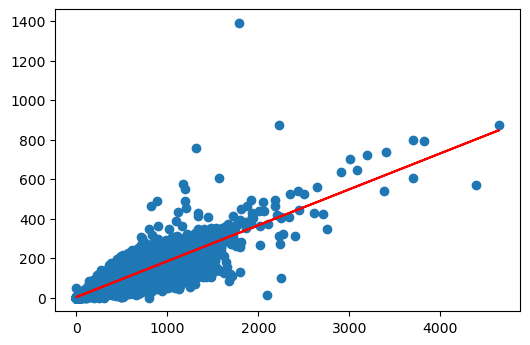

In [9]:
# model selection
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split

# X = Features, y = Target
X = np.array(population['25 - 39']).reshape(-1,1)
y = np.array(population['0 - 2'  ]).reshape(-1,1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=0)

# model train : AI part
model = LinearRegression()
model.fit(X_train,y_train)

# model score
print('Train score : ', model.score(X_train,y_train).round(2))
print('Test  score : ', model.score(X_test,y_test).round(2))

# model prediction
y_prediction = model.predict(X_test)

# visual result
plt.figure(dpi=100)
plt.scatter(X,y)
plt.plot(X_test, y_prediction, c='r');

## Cross Validation : 
- mélange aléatoire du Train set / Test set
- découpe du Train set en 100
- normalisation du Train score

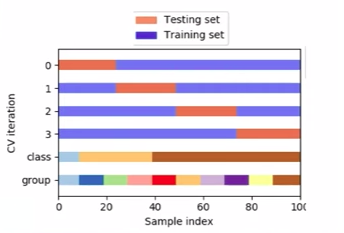

In [10]:
from sklearn.model_selection import cross_val_score

print('Train score (CV 100) : ', cross_val_score(LinearRegression(),
                                 X_train, y_train,
                                 cv=100).mean().round(2))

Train score (CV 100) :  0.85


## Amélioration du modèle
#### Le **preprocessing** optimise la prédiction de LinearRegression.
#### Purifier la data avec le modèle **IsolationForest**, un excellent détecteur d'anomalies moderne.

## Nettoyer les outliers : IsolationForest

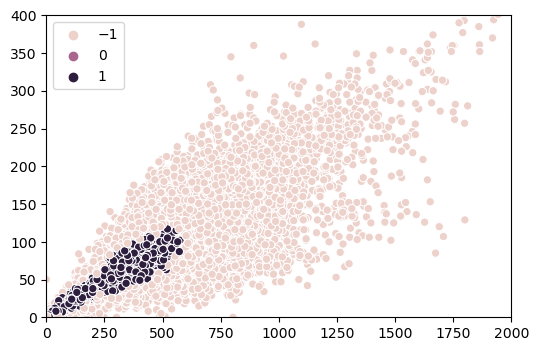

In [11]:
# model selection
from sklearn.ensemble import IsolationForest

# Xy = selected Feature + Target
Xy = np.array(population[['0 - 2', '25 - 39']])

# model train : AI part
model = IsolationForest(contamination=0.2, random_state=0)
model.fit(Xy)

# model prediction
prediction = model.predict(Xy)

# visual result
plt.figure(dpi=100)
plt.axis(xmax=2000, ymax=400)
sns.scatterplot(x=Xy[:,1], y=Xy[:,0], hue=prediction);

# 'novelty detection' test set
LocalOutlierFactor_test_set = Xy[prediction == -1]

# preprocessed data
Xy = Xy[prediction == 1]

**nuage violet foncé = 80% de data**

**nuage rose = pollution visuelle par 20% de data**

## Effectuer une régression linéaire

Train score (CV 100): 0.94
Test score : 0.94
[[0.18968485]] [0.82774109]


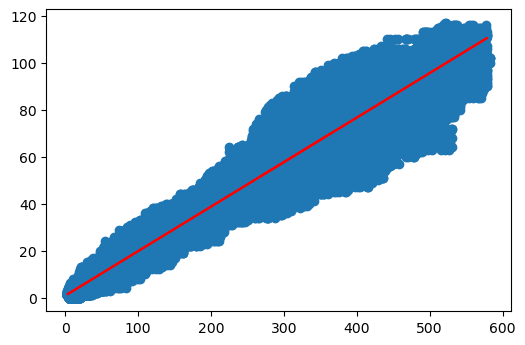

In [12]:
# model selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# X = select Feature, y = Target
X = Xy[:,1].reshape(-1,1)
y = Xy[:,0].reshape(-1,1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=0)

# model train : AI part
model = LinearRegression()
model.fit(X_train,y_train)

# model score
print('Train score (CV 100):', cross_val_score(LinearRegression(),
                                               X_train, y_train,
                                               cv=40).mean().round(2))

print('Test score :', model.score(X_test, y_test).round(2))

# model prediction
prediction = model.predict(X_test)

# visual result
plt.figure(dpi=100)
plt.scatter(X,y)
plt.plot(X_test, prediction, c='r');

# prediction coordinates
print(model.coef_, model.intercept_)

## Aller plus loin : Ensemble Learning
Gagner les derniers % : **"Wisdom of the crowd"**

La faiblesse d'un modèle est compensée par la force d'un autre modèle.

3 conditions pour l'ensemble : **GRAND**, **COMPETENT**, **DIVERSIFIE**
- **GRAND** : quantité de Data
- **COMPETENT** : 50% minimum de performance par modèle
- **DIVERSITE** : diversité dans les modèles

3 méthodes : **BAGGING**, **BOOSTING**, **STACKING**.







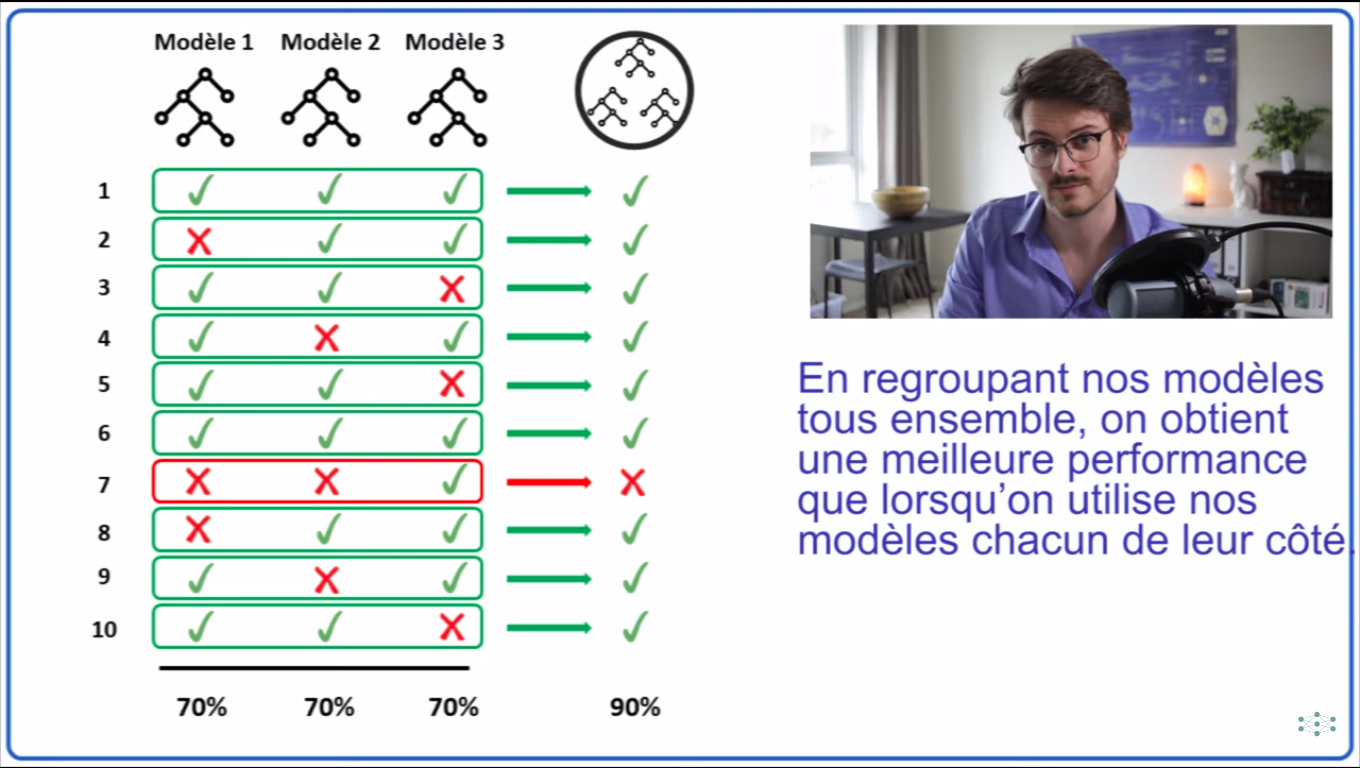
source : Youtube Machine Learnia
